In [1]:
import h5py
from warnings import warn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import xarray as xr

import seaborn as sns
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature


from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Concatenate

# this way I do not have to reshape the data
from keras.backend import set_image_data_format, image_data_format
from tensorflow.compat.v1 import disable_eager_execution
from tensorflow import executing_eagerly
from tensorflow.python.compiler.mlcompute import mlcompute

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

set_image_data_format('channels_first')
assert image_data_format(
) == 'channels_first', "Plase set keras backend as channels first."

# APPLE SPECIFIC IMPLEMENTATION
disable_eager_execution()
assert executing_eagerly(
) is False, "Please do not set to eager execution for this program."

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
mlcompute.set_mlc_device(
    device_name='gpu')  # Available options are 'cpu', 'gpu', and 'any'.

# currently installed theme will be used to
# set plot style if no arguments provided
# jtplot.style()

# Introduction

This notebook contains code and data relative to the general experiment, but whose purpose did not fit perfectly inside other notebooks. See each section for the specific explanation.

# Loading data

## CAM5 data

In [2]:
# load the CAM5 model data
simulated_data = h5py.File("./data.nosync/georeferenced_wind_extremewearge_2005.h5", 'r')
# this data contains:
# (data) the 3 variables of interest (U850, UBOT, V850) (see https://extremeweatherdataset.github.io)
# (boxes) contains information as to where the cyclon is
# (latitude)
# (longitude)
# (time) saved as int8, contains the hour, day, month and year of the data

Since using all of the variables would be too expensive, and since most of the interest lies on the **U850** variables, only this shall be selected. This allows to keep at a minimum the amount of RAM used.
This data shall be saved in a ```numpy``` array, which is fairly easy to treat. The time, latitude and longitude shall be kept in the h5df file, since there is no need to move them to new variables.

In [3]:
# just consider the U850 variable (from the pre-processed data, in the 1st column)
simulated_U850 = simulated_data['data'][:,0,:,:]

print("Data shape:", simulated_U850.shape)
# the orded of dimensions is as follow: (time, lat, lon)

Data shape: (1456, 768, 1152)


In [4]:
# load time and change from int to numpy datetime64
simulated_time = simulated_data['time'][()].astype("<M8[us]")

## Real data PhysicalSociety

In [5]:
# load the model generated data
print("Load real data")
datapath = './data.nosync/uwnd.sig995.2005.nc'
dataset = xr.load_dataset(datapath)
# this data is already for the year 2005

Load real data


## Real Data Copernicus

In [5]:
# load the model generated data
print("Load real data")
datapath = "./data.nosync/copernicus_daily.nc"
dataset2 = xr.load_dataset(datapath)
# this data is already for the year 2005

Load real data


# Find Major Hurricanes

For this experiment, only the Copernicus data is employed.

In this experiment, using the trained classifier and the real data, I shall see if it is possible to: 
- Identify by hand major Atlantic cyclones for the 2005 hurricane season, e.g. Katrina.
- See if the classifier can identify them as well.

While the scope of this small experiment is very limited, and all possible results, be it positive or negative, should be considered as just some preliminary study, mostly due to a lack of method, they nonetheless could be interesting and a start for further analysis.

## Test on Katrina

The data regarding the position and time was taken from [this](https://4-h.org/wp-content/uploads/2020/03/Page-3-Hurricane-Katrina-Coordinates.pdf) pdf.

In [6]:
# major date
# in this case, just a single reference date for each is considered
katrina_date = np.datetime64("2005-08-26")
# emily_dates = np.arange("2005-07-11","2005-07-21",dtype='datetime64[D]')
# rita_dates = np.arange("2005-09-18","2005-09-26",dtype='datetime64[D]')
# wilma_dates = np.arange("2005-10-15","2005-10-27",dtype='datetime64[D]')

In [7]:
katrina_coords = (25.9, 360-80.3)

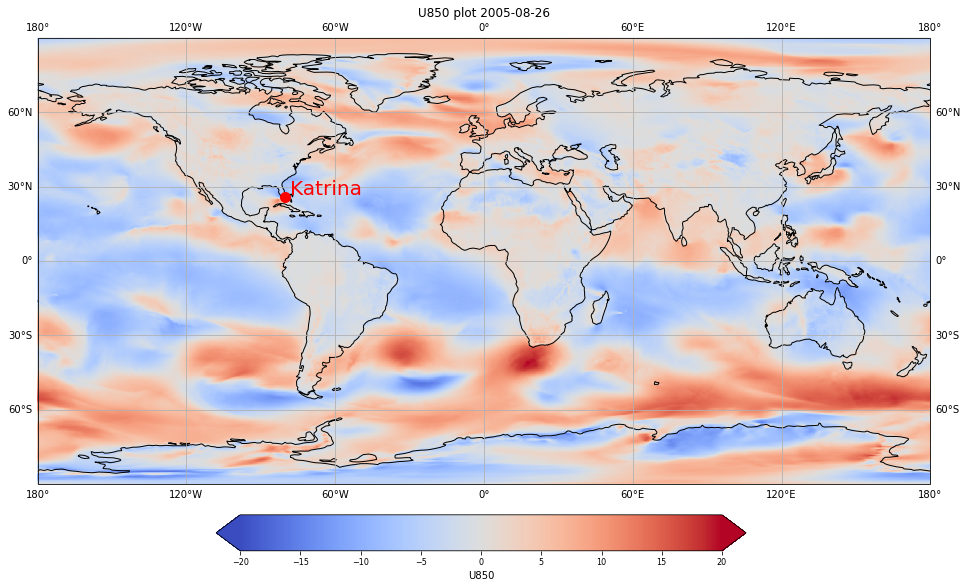

In [10]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot "+str(katrina_date.astype("M8[D]")))
ax.set_global()
mm = ax.pcolormesh(dataset2.longitude,
                   dataset2.latitude,
                   dataset2.u10.values[np.where(dataset2.time.values == katrina_date)[0][0],:,:],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm, vmin = -20, vmax = 20)

ax.plot(katrina_coords[-1],
                    katrina_coords[0],
                    color='red',
                   marker='o',
                  markersize=10,
                    transform=ccrs.PlateCarree())

ax.text(katrina_coords[-1]-360+2, katrina_coords[0]+1, "Katrina", color = 'red', size = 20)
ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/katrina.png", dpi=300)
plt.show()
plt.close()

While the above plot allows to identify the hurricane in the map, it does not allow to see the distinct features. Let us see a more zoomed version.

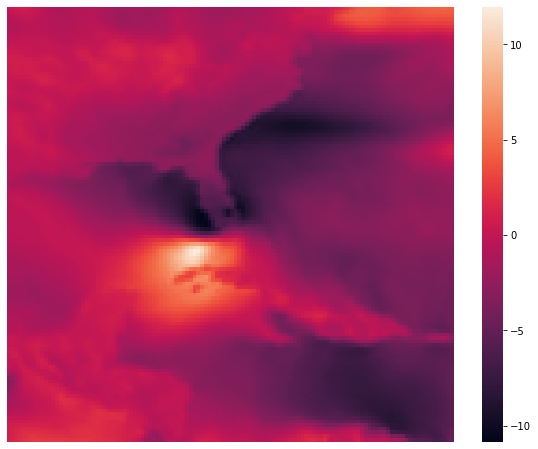

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(dataset2.u10[
    np.where(dataset2.time.values == katrina_date)[0][0],
    (np.where(np.isclose(dataset2.latitude, katrina_coords[0], 0.01))[0][0] -
     60):
    (np.where(np.isclose(dataset2.latitude, katrina_coords[0], 0.01))[0][0] +
     60), 
    (np.where(np.isclose(dataset2.longitude, katrina_coords[1], 0.001))[0][0] -
     60):
    (np.where(np.isclose(dataset2.longitude, katrina_coords[1], 0.001))[0][0] +
     60)])
plt.axis('off')
plt.savefig("./images/katrina_close.png", dpi = 300)
plt.show()
plt.close()

Okay, so **this** is the image of the actual Katrina hurricane: interesting. Now, the next step would be to use the classifier to see if it can manage to correctly identify it as a cyclone.

In [20]:
katrina_wind = dataset2.u10[
    np.where(dataset2.time.values == katrina_date)[0][0],
    (np.where(np.isclose(dataset2.latitude, katrina_coords[0], 0.01))[0][0] -
     60):
    (np.where(np.isclose(dataset2.latitude, katrina_coords[0], 0.01))[0][0] +
     60), 
    (np.where(np.isclose(dataset2.longitude, katrina_coords[1], 0.001))[0][0] -
     60):
    (np.where(np.isclose(dataset2.longitude, katrina_coords[1], 0.001))[0][0] +
     60)]

In [21]:
# need to give the data in the correct format
katrina_wind = np.expand_dims(katrina_wind.values, axis = [0,1])

In [14]:
# this few layer ahead are needed, since the VGG16 classifier takes only 3 channel images
# (I just take 3 identical channels)
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=katrina_wind.shape[1:])
img_conc = Concatenate(axis = 1)([new_input, new_input, new_input])  
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

# the model is loaded. This is the part trained locally
print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./trained_models/model_just_850_4/")

Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)


In [15]:
print(
    "Probability, accordin to model, that the real image presented is of a cyclone:",
    U850_model.predict(base_model.predict(katrina_wind))[0][0])

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Probability, accordin to model, that the real image presented is of a cyclone: 0.9791879


Yes! It manages to find Hurrican Katrina. While a very limited result, it shows very strong possibilities.

## Test on Maria

The time and location come from [this link](https://www.nhc.noaa.gov/data/tcr/AL142005_Maria.pdf).

In [22]:
# major date
# in this case, just a single reference date for each is considered
maria_date = np.datetime64("2005-09-04")
# emily_dates = np.arange("2005-07-11","2005-07-21",dtype='datetime64[D]')
# rita_dates = np.arange("2005-09-18","2005-09-26",dtype='datetime64[D]')
# wilma_dates = np.arange("2005-10-15","2005-10-27",dtype='datetime64[D]')

In [23]:
maria_coords = (27.5, 360-55.1)

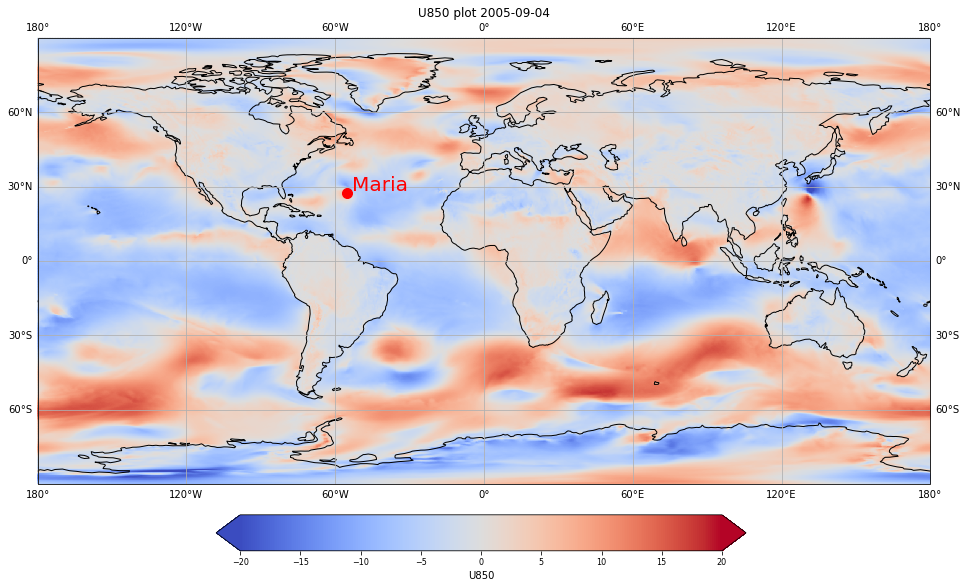

In [24]:
# We already tried pcolormesh (Module 1)

fig = plt.figure(figsize=(16, 10))  # x,y(inches)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("U850 plot "+str(maria_date.astype("M8[D]")))
ax.set_global()
mm = ax.pcolormesh(dataset2.longitude,
                   dataset2.latitude,
                   dataset2.u10.values[np.where(dataset2.time.values == maria_date)[0][0],:,:],
                   transform=ccrs.PlateCarree(),
                   cmap=mpl.cm.coolwarm, vmin = -20, vmax = 20)

ax.plot(maria_coords[-1],
                    maria_coords[0],
                    color='red',
                   marker='o',
                  markersize=10,
                    transform=ccrs.PlateCarree())

ax.text(maria_coords[-1]+2-360, maria_coords[0]+1, "Maria", color = 'red', size = 20)
ax.coastlines()
ax.gridlines(draw_labels=True)

#- add colorbar
cbar_ax = fig.add_axes([0.28, 0.10, 0.46,
                        0.05])  #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='horizontal')
cbar.set_label('U850')
cbar.ax.tick_params(labelsize=8)
plt.savefig("./images/maria.png", dpi=300)
plt.show()
plt.close()

While the above plot allows to identify the hurricane in the map, it does not allow to see the distinct features. Let us see a more zoomed version.

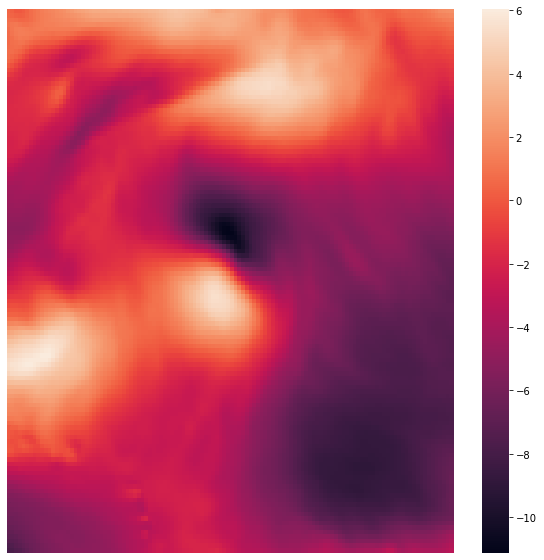

In [30]:
plt.figure(figsize=(10, 10))
sns.heatmap(dataset2.u10[np.where(dataset2.time.values == maria_date)[0][0], (
    np.where(np.isclose(dataset2.latitude, maria_coords[0], 0.01))[0][0] - 60
):(np.where(np.isclose(dataset2.latitude, maria_coords[0], 0.01))[0][0] +
   60), (
       np.where(np.isclose(dataset2.longitude, maria_coords[1], 0.001))[0][0] -
       60
   ):(np.where(np.isclose(dataset2.longitude, maria_coords[1], 0.001))[0][0] +
      60)])
plt.axis('off')
plt.savefig('./images/maria_close.png', dpi = 300)
plt.show()
plt.close()

Okay, so **this** is the image of the actual Katrina hurricane: interesting. Now, the next step would be to use the classifier to see if it can manage to correctly identify it as a cyclone.

In [26]:
maria_wind = dataset2.u10[
    np.where(dataset2.time.values == maria_date)[0][0],
    (np.where(np.isclose(dataset2.latitude, maria_coords[0], 0.01))[0][0] -
     60):
    (np.where(np.isclose(dataset2.latitude, maria_coords[0], 0.01))[0][0] +
     60), 
    (np.where(np.isclose(dataset2.longitude, maria_coords[1], 0.001))[0][0] -
     60):
    (np.where(np.isclose(dataset2.longitude, maria_coords[1], 0.001))[0][0] +
     60)]

In [27]:
# need to give the data in the correct format
maria_wind = np.expand_dims(maria_wind.values, axis = [0,1])

In [28]:
# this few layer ahead are needed, since the VGG16 classifier takes only 3 channel images
# (I just take 3 identical channels)
print("Loading VGG (with concatenation of the single channel)")
new_input = Input(shape=katrina_wind.shape[1:])
img_conc = Concatenate(axis = 1)([new_input, new_input, new_input])  
VGG_model = VGG16(include_top=False, input_tensor=img_conc)
base_model = Model(inputs = VGG_model.input, outputs = VGG_model.layers[15].output)

# the model is loaded. This is the part trained locally
print("Load pre-trained CNN classifier for cyclons (U850 specific)")
U850_model = load_model("./trained_models/model_just_850_4/")

Loading VGG (with concatenation of the single channel)
Load pre-trained CNN classifier for cyclons (U850 specific)


In [29]:
print(
    "Probability, accordin to model, that the real image presented is of a cyclone:",
    U850_model.predict(base_model.predict(maria_wind))[0][0])

/Users/leonardoalchieri/anaconda3/envs/tf_apple_2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Probability, accordin to model, that the real image presented is of a cyclone: 0.9659909


It also manages to identify Hurricane Maria. These results show the strength of teh model to predict quite correctly real cyclones, even if trained on "fake" (simulated) data.

# Future perspectives

Given the quite interesting results on *hand-picked* examples, one could try to create a dataset to recognize on **real** data the presence or not of hurricanes. Indeed, the biggest limitation of my work is a test on real data, since the one that I have performed did not have really hurricanes, mostly due to "miss-placement" of cyclones in the simulated data, both in space and time probably. 

As for the last remark, I tried to contact on of the authors of the dataset, who told me there may be some problems related to the CAM5 simulation. For example, it does not take into consideration the presence or not of a **leap year**, i.e. the early data is always taken to be 365 days. Also, the absence of a day in the 2005 data could pose some problems.